In [1]:
# constants that the old script wanted

norm = 1
dataset = "pdfrate"
in_file = "models_final_real/pdfrate_sigmoid.h5:custom_sigmoid"
code_file = None
model_type = "pdf"

In [2]:
from src.data import get_data

x_train, y_train, x_test, y_test = get_data(dataset)


dataset: pdfrate codes: None
(8066, 135)
(2016, 135)


In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [4]:
from src.models import load_model, load_mnist_model, sign, load_general_model

model, _ = load_general_model(x_train, y_train, in_file,
                           1024, None, model_type)

model.evaluate(x_test, y_test, verbose=2)

2016/2016 - 0s - loss: 0.0064 - accuracy: 0.9995


[0.006374326277312191, 0.99950397]

In [5]:
from src.stabilization import stabilize_some_l1

print("doing the stabilize")
new_model = stabilize_some_l1(model, x_test, y_test, allowed_layers=(0, 2), thresh=0.9, no_accuracy=True)

doing the stabilize
2016/2016 [==============================] - 0s 19us/sample - loss: 0.0064 - accuracy: 0.9995
current acc: 0.9995039701461792
layer_shape: (135, 16)
layer size: 135
layer: 0, neuron: 0, rob: 111.03518676757812, acc: none, ok: True
layer: 0, neuron: 1, rob: 96.97989654541016, acc: none, ok: True
layer: 0, neuron: 2, rob: 117.571533203125, acc: none, ok: True
layer: 0, neuron: 3, rob: 100.46511840820312, acc: none, ok: True
layer: 0, neuron: 4, rob: 113.47007751464844, acc: none, ok: True
layer: 0, neuron: 5, rob: 97.23228454589844, acc: none, ok: True
layer: 0, neuron: 6, rob: 97.40857696533203, acc: none, ok: True
layer: 0, neuron: 7, rob: 106.48064422607422, acc: none, ok: True
layer: 0, neuron: 8, rob: 110.68678283691406, acc: none, ok: True
layer: 0, neuron: 9, rob: 108.27071380615234, acc: none, ok: True
layer: 0, neuron: 10, rob: 105.21488189697266, acc: none, ok: True
layer: 0, neur

In [7]:
new_model.evaluate(x_test, y_test)

2016/2016 [==============================] - 0s 25us/sample - loss: 0.0475 - accuracy: 0.9836


[0.047513851175031124, 0.98363096]

In [5]:
layer_weights = model.get_weights()[0]

l_inf_norms = tf.norm(layer_weights, ord=np.inf, axis=0)
# l1_norms = tf.norm(layer_weights, ord=1, axis=0)
l2_norms = tf.norm(layer_weights, ord=2, axis=0)

epsilons = l_inf_norms / l2_norms

print(epsilons)

tf.Tensor(
[0.36239436 0.24881794 0.46349615 0.2689652  0.40569815 0.2417419
 0.25206894 0.32469407 0.37254184 0.33332732 0.3065512  0.25134656
 0.39579377 0.2658677  0.30822107 0.26179138], shape=(16,), dtype=float32)


In [6]:
epsilons_list = list(epsilons.numpy())

epsilons_and_indices = [(eps, index) for index, eps in enumerate(epsilons_list)]

# sort in increasing order of epsilons
epsilons_and_indices.sort(key=lambda x: x[0], reverse=True)

order_of_indices = [x[1] for x in epsilons_and_indices]

In [7]:
# Set up the attack we are going to run below
from src.attacks import l0_multiclass_attack

np.random.seed(1)
sample_size = 100
test_indices = np.random.choice(x_test.shape[0], size=sample_size, replace=False)

num_classes = np.amax(y_test) + 1


def run_attack():
    def run_attack_for_index(test_index):
        current_class = int(y_test[test_index])
        x0 = x_test[test_index]

        norm, _ = l0_multiclass_attack(x0, current_class, num_classes, model, change_at_once=1)
        return norm

    return [run_attack_for_index(index) for index in test_indices]

In [8]:
# now, stabilize the neurons in order of increasing epsilons

min_norms = []

# run on the un-stabilized model first
min_norms.append(run_attack())
losses = []
accuracies = []

loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

losses.append(loss)
accuracies.append(accuracy)

for changed_count, index in enumerate(order_of_indices):
    print(epsilons_list[index])
    all_weights = model.get_weights()
    layer_weights = all_weights[0]
    neuron_weights = layer_weights[:, index]
    l_inf_norm = tf.norm(neuron_weights, ord=np.inf)

    new_neuron_weights = tf.math.sign(neuron_weights) * l_inf_norm

    layer_weights[:, index] = new_neuron_weights

    all_weights[0] = layer_weights

    model.set_weights(all_weights)

    # todo, perhaps train biases as part of this loop?

    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

    losses.append(loss)
    accuracies.append(accuracy)

    # now, do an adversarial test
    # let's just run custom JSMA here
    min_norms.append(run_attack())
    print(min_norms)


2016/2016 - 0s - loss: 0.0064 - accuracy: 0.9995
0.46349615
2016/2016 - 0s - loss: 0.0075 - accuracy: 0.9985
[[6, 6, 8, 2, 6, 6, 6, 6, 6, 6, 2, 4, 4, 4, 8, 6, 4, 4, 6, 6, 6, 6, 6, 2, 6, 4, 2, 6, 8, 6, 4, 6, 10, 4, 4, 6, 2, 8, 4, 6, 8, 6, 6, 6, 6, 6, 6, 6, 4, 2, 4, 8, 4, 4, 2, 6, 6, 6, 6, 4, 4, 4, 10, 2, 8, 2, 6, 6, 6, 6, 4, 6, 6, 4, 6, 6, 10, 6, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 6, 6, 8, 4, 6, 4, 6, 6, 6], [8, 6, 10, 2, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 6, 2, 4, 4, 2, 4, 10, 6, 4, 4, 10, 4, 4, 4, 4, 10, 6, 6, 8, 6, 4, 6, 4, 6, 4, 4, 4, 2, 4, 10, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 12, 2, 10, 2, 6, 6, 6, 4, 4, 8, 6, 4, 4, 4, 10, 4, 4, 4, 6, 4, 4, 4, 4, 8, 6, 4, 4, 4, 6, 4, 6, 8, 6, 4, 6, 4, 4, 6]]
0.40569815
2016/2016 - 0s - loss: 0.0073 - accuracy: 0.9980
[[6, 6, 8, 2, 6, 6, 6, 6, 6, 6, 2, 4, 4, 4, 8, 6, 4, 4, 6, 6, 6, 6, 6, 2, 6, 4, 2, 6, 8, 6, 4, 6, 10, 4, 4, 6, 2, 8, 4, 6, 8, 6, 6, 6, 6, 6, 6, 6, 4, 2, 4, 8, 4, 4, 2, 6, 6, 6, 6, 4, 4, 4, 10, 2, 8, 2, 6, 6, 6, 6, 4

In [9]:
all_weights_at_end = model.get_weights()

In [10]:


def compute_robustness(min_norm_list):
    return sum(min_norm_list) / len(min_norm_list)

robustnesses = [compute_robustness(min_norm)
                for min_norm in min_norms]

print(min_norms)

print(robustnesses)

together = list(zip(robustnesses, accuracies))
for pair in together:
    print(pair)



[[6, 6, 8, 2, 6, 6, 6, 6, 6, 6, 2, 4, 4, 4, 8, 6, 4, 4, 6, 6, 6, 6, 6, 2, 6, 4, 2, 6, 8, 6, 4, 6, 10, 4, 4, 6, 2, 8, 4, 6, 8, 6, 6, 6, 6, 6, 6, 6, 4, 2, 4, 8, 4, 4, 2, 6, 6, 6, 6, 4, 4, 4, 10, 2, 8, 2, 6, 6, 6, 6, 4, 6, 6, 4, 6, 6, 10, 6, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 6, 6, 8, 4, 6, 4, 6, 6, 6], [8, 6, 10, 2, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 8, 4, 4, 4, 4, 4, 6, 4, 6, 2, 4, 4, 2, 4, 10, 6, 4, 4, 10, 4, 4, 4, 4, 10, 6, 6, 8, 6, 4, 6, 4, 6, 4, 4, 4, 2, 4, 10, 4, 4, 4, 4, 6, 4, 6, 4, 6, 4, 12, 2, 10, 2, 6, 6, 6, 4, 4, 8, 6, 4, 4, 4, 10, 4, 4, 4, 6, 4, 4, 4, 4, 8, 6, 4, 4, 4, 6, 4, 6, 8, 6, 4, 6, 4, 4, 6], [8, 6, 10, 2, 4, 4, 4, 6, 4, 4, 4, 4, 6, 4, 10, 4, 4, 6, 4, 4, 8, 4, 6, 2, 4, 4, 0, 4, 10, 6, 4, 4, 10, 4, 6, 6, 4, 10, 6, 6, 8, 6, 4, 6, 4, 6, 4, 4, 6, 2, 4, 10, 6, 4, 4, 4, 6, 4, 6, 6, 6, 6, 12, 4, 10, 2, 6, 6, 6, 4, 4, 8, 8, 4, 4, 4, 10, 4, 4, 4, 8, 4, 4, 4, 4, 8, 6, 2, 4, 4, 6, 4, 6, 8, 6, 4, 6, 4, 4, 6], [10, 6, 10, 2, 6, 6, 6, 8, 6, 6, 4, 6, 4, 4, 10, 6, 4, 4, 6, 6, 8, 6, 8, 

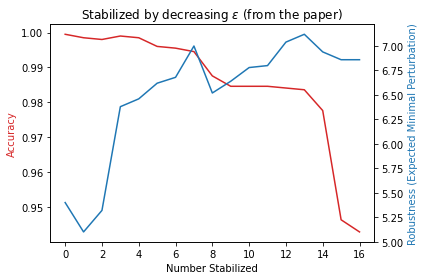

In [11]:
# now, plot accuracy vs number changed
# and robustness vs number changed

from matplotlib import pyplot as plt

x = [*range(len(order_of_indices) + 1)]

fig, ax1 = plt.subplots()


color = 'tab:red'
ax1.set_xlabel("Number Stabilized")
ax1.set_ylabel("Accuracy", color=color)
ax1.plot(x, accuracies, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Robustness (Expected Minimal Perturbation)', color=color)
ax2.plot(x, robustnesses, color=color)

ax1.set_title("Stabilized by decreasing $\epsilon$ (from the paper)")

fig.tight_layout()
plt.show()

In [12]:
import json

data = {"min_norms": [list(min_norm) for min_norm in min_norms],
        "accuracies": [a.item() for a in accuracies], "model": in_file}



out_file = "500_datapoints_test_epsilons_reversed.json"

with open(out_file, "w") as out_handle:
    json.dump(data, out_handle)